## The Dataset
The dataset used for this project comes from Insideairbnb.com, an anti-Airbnb lobby group that scrapes Airbnb listings, reviews and calendar data for multiple cities around the world. The dataset was scraped on 9 September 2021 and contains information on all Paris Airbnb listings that were live on the site on that date.

## Cleaning and Preprocessing

### Importing the libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import dataframe_image as dfi
from statsmodels.tsa.seasonal import seasonal_decompose

In [74]:
# import the file

raw_df = pd.read_csv('/Users/brendan/Desktop/Python/Two Sigma Projects/Airbnb/Paris_listings.csv')
print(f"The dataset contains {len(raw_df)} AirBnb listings.")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)
raw_df.isna().mean() *100





The dataset contains 50133 AirBnb listings.


id                                                0.000000
listing_url                                       0.000000
scrape_id                                         0.000000
last_scraped                                      0.000000
name                                              0.095745
description                                       1.603734
neighborhood_overview                            40.021543
picture_url                                       0.001995
host_id                                           0.000000
host_url                                          0.000000
host_name                                         0.067820
host_since                                        0.067820
host_location                                     0.255321
host_about                                       48.267608
host_response_time                               53.535595
host_response_rate                               53.535595
host_acceptance_rate                             51.6625

## Dropping Initial columns
+ drop free text columns
+ drop columns not useful for predicting price

In [75]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 
                'host_id', 'host_url', 'host_name', 'host_since','host_location', 'host_about', 'host_thumbnail_url', 
                'host_picture_url', 'host_verifications', 'calendar_last_scraped', 'bathrooms', 'neighbourhood_group_cleansed',
               'license']
df = raw_df.drop(cols_to_drop, axis=1)


Now check for columns with majority null entries

In [76]:
df.isna().sum()

id                                                  0
host_response_time                              26839
host_response_rate                              26839
host_acceptance_rate                            25900
host_is_superhost                                  34
host_neighbourhood                              13528
host_listings_count                                34
host_total_listings_count                          34
host_has_profile_pic                               34
host_identity_verified                             34
neighbourhood                                   20064
neighbourhood_cleansed                              0
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms_text                                    103
bedrooms                    

In [77]:
df.isna().mean()*100

id                                                0.000000
host_response_time                               53.535595
host_response_rate                               53.535595
host_acceptance_rate                             51.662578
host_is_superhost                                 0.067820
host_neighbourhood                               26.984222
host_listings_count                               0.067820
host_total_listings_count                         0.067820
host_has_profile_pic                              0.067820
host_identity_verified                            0.067820
neighbourhood                                    40.021543
neighbourhood_cleansed                            0.000000
latitude                                          0.000000
longitude                                         0.000000
property_type                                     0.000000
room_type                                         0.000000
accommodates                                      0.0000

In [78]:

#df.drop(['host_response_time', 'host_response_rate',
        #'host_acceptance_rate','neighbourhood', 'neighbourhood_group_cleansed',
        #'bathrooms','calendar_updated','license', 'first_review', 'last_review',
        #'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        #'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value'], axis=1, inplace=True)

# set id as index
#df.set_index('id', inplace=True)


Save latitude and longitude into a DataFrame, for later use; then drop the data from the working DataFrame

In [79]:

lat_long = df[['latitude', 'longitude']]

In [80]:
df.drop(['latitude', 'longitude'],axis=1, inplace=True)

In [81]:
df.isna().mean()*100

id                                                0.000000
host_response_time                               53.535595
host_response_rate                               53.535595
host_acceptance_rate                             51.662578
host_is_superhost                                 0.067820
host_neighbourhood                               26.984222
host_listings_count                               0.067820
host_total_listings_count                         0.067820
host_has_profile_pic                              0.067820
host_identity_verified                            0.067820
neighbourhood                                    40.021543
neighbourhood_cleansed                            0.000000
property_type                                     0.000000
room_type                                         0.000000
accommodates                                      0.000000
bathrooms_text                                    0.205453
bedrooms                                         18.8159

In [82]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

1999

In [83]:

df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)


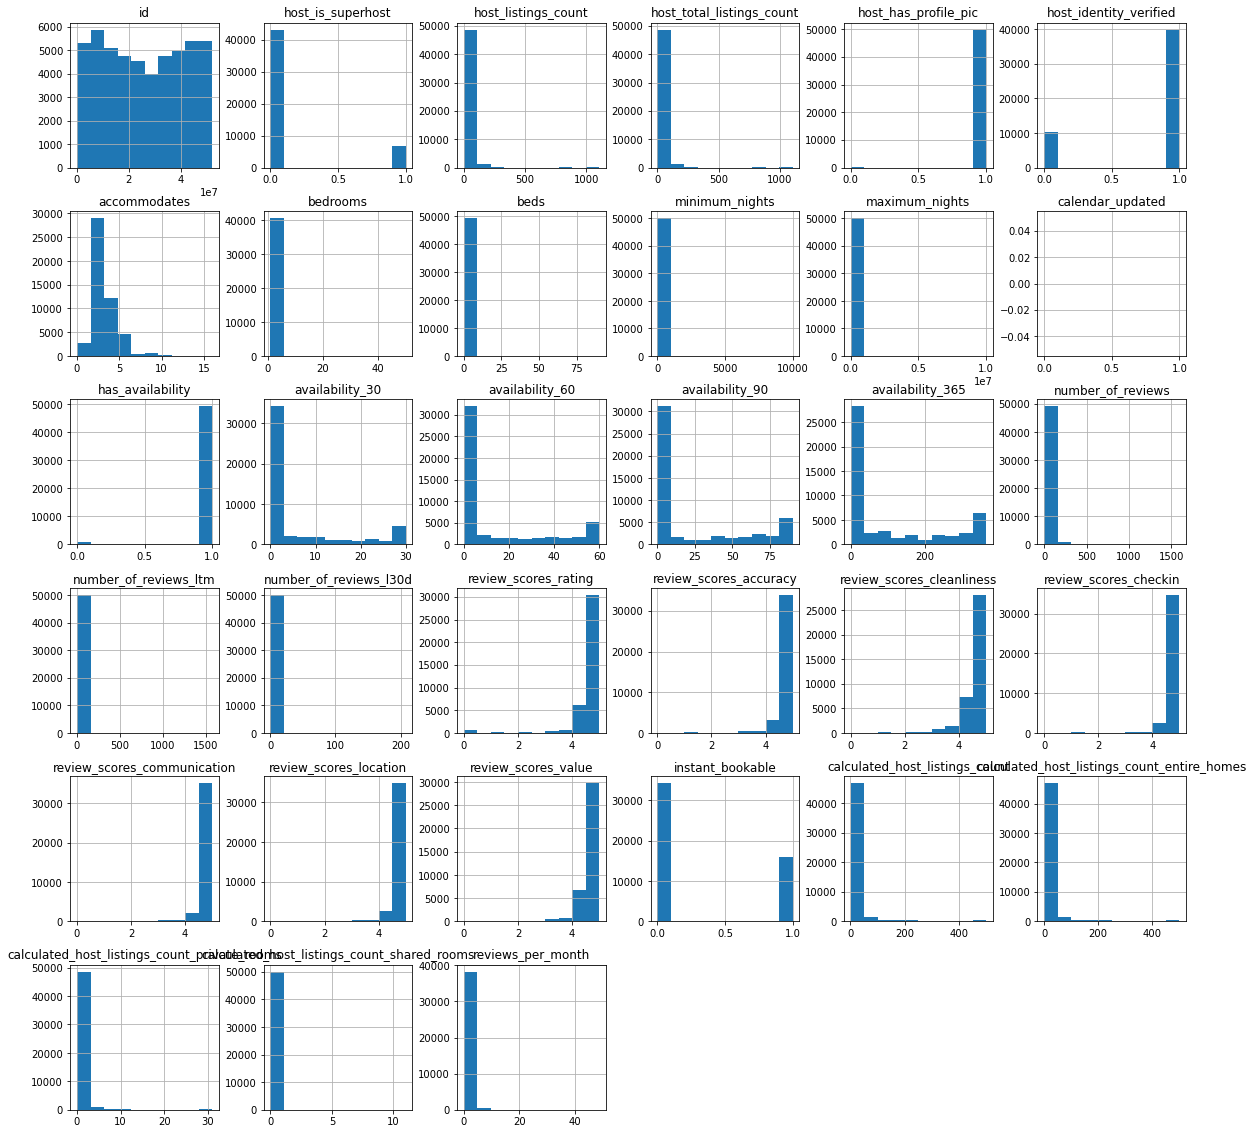

In [84]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories

df.hist(figsize=(20,20))
plt.savefig("airbnb_hist", bbox_inches='tight', dpi=100)

In [85]:

df.drop(['has_availability', 'host_has_profile_pic', 'calendar_updated'], axis=1, inplace=True)
df.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5396,within an hour,100%,89%,0.0,Saint-Paul - Ile Saint-Louis,1.0,1.0,1.0,"Paris, Ile-de-France, France",Hôtel-de-Ville,Entire rental unit,Entire home/apt,2,1 bath,NaN,1.0,"[""Hot water kettle"", ""Cooking basics"", ""Smoke alarm"", ""Oven"", ""Long term stays allowed"", ""Hot water"", ""Shampoo"", ""Heating"", ""Refrigerator"", ""Shower gel"", ""Essentials"", ""Bed linens"", ""Toaster"", ""Dedicated workspace"", ""Cleaning products"", ""Extra pillows and blankets"", ""Stove"", ""Drying rack for clothing"", ""Clothing storage: closet"", ""Fire extinguisher"", ""Body soap"", ""Cable TV"", ""Kitchen"", ""Hangers"", ""TV with standard cable"", ""Wifi"", ""Hair dryer"", ""Dishes and silverware"", ""Host greets you"", ""Washer""]",$110.00,2,1125,0,3,29,29,260,35,3,2013-09-22,2020-08-08,4.51,4.55,4.47,4.78,4.82,4.96,4.53,0,1,1,0,0,2.68
1,7397,within an hour,100%,80%,1.0,Le Marais,4.0,4.0,1.0,NaN,Hôtel-de-Ville,Entire rental unit,Entire home/apt,4,1 bath,2.0,2.0,"[""Cooking basics"", ""Smoke alarm"", ""Iron"", ""Oven"", ""Long term stays allowed"", ""Hot water"", ""Shampoo"", ""Heating"", ""Refrigerator"", ""Essentials"", ""Bed linens"", ""Microwave"", ""Dedicated workspace"", ""Extra pillows and blankets"", ""Stove"", ""Cable TV"", ""Kitchen"", ""Hangers"", ""Carbon monoxide alarm"", ""Paid parking off premises"", ""TV with standard cable"", ""Wifi"", ""Coffee maker"", ""Hair dryer"", ""Dishes and silverware"", ""Host greets you"", ""Washer""]",$100.00,10,130,0,0,20,257,278,9,2,2011-08-11,2021-08-18,4.70,4.79,4.44,4.91,4.88,4.92,4.70,0,1,1,0,0,2.26
2,7964,within a day,60%,0%,0.0,Gare du Nord - Gare de I'Est,0.0,0.0,1.0,NaN,Opéra,Entire rental unit,Entire home/apt,2,1 bath,1.0,1.0,"[""Essentials"", ""TV with standard cable"", ""Wifi"", ""Cable TV"", ""Dedicated workspace"", ""Kitchen"", ""Hangers"", ""Iron"", ""Long term stays allowed"", ""Heating"", ""Washer""]",$130.00,6,365,13,43,73,348,6,0,0,2014-09-11,2015-09-14,4.80,5.00,5.00,5.00,5.00,5.00,5.00,0,1,1,0,0,0.07
3,9359,within an hour,100%,20%,0.0,Châtelet - Les Halles - Beaubourg,3.0,3.0,1.0,NaN,Louvre,Entire rental unit,Entire home/apt,2,1 bath,1.0,1.0,"[""Essentials"", ""Wifi"", ""Kitchen"", ""Hair dryer"", ""Elevator"", ""Long term stays allowed"", ""Heating""]",$75.00,180,365,0,0,0,28,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0,NaN
4,9952,within an hour,100%,100%,1.0,République,1.0,1.0,1.0,"Paris, Ile-de-France, France",Popincourt,Entire rental unit,Entire home/apt,2,1 bath,1.0,1.0,"[""TV"", ""Cooking basics"", ""Smoke alarm"", ""Luggage dropoff allowed"", ""Iron"", ""Oven"", ""Long term stays allowed"", ""Hot water"", ""Heating"", ""Refrigerator"", ""Shower gel"", ""Essentials"", ""Bed linens"", ""Microwave"", ""Dedicated workspace"", ""Extra pillows and blankets"", ""Stove"", ""First aid kit"", ""Kitchen"", ""Hangers"", ""Paid parking off premises"", ""Wifi"", ""Coffee maker"", ""Hair dryer"", ""Dishes and silverware"", ""Host greets you""]",$80.00,4,31,1,2,2,198,31,6,1,2016-08-04,2021-06-23,4.94,4.97,4.87,5.00,4.90,4.90,4.94,0,1,1,0,0,0.50


In [86]:
df.columns

Index(['id', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_roo

## Description of each column:


+ host_since - date that the host first joined Airbnb
+ host_response_time - average amount of time the host takes to reply to messages
+ host_response_rate - proportion of messages that the host replies to
+ host_is_superhost - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
+ host_listings_count - how many listings the host has in total
+ host_identity_verified - whether or not the host has been verified with id
+ property_type - type of property, e.g. house or flat
+ room_type - type of listing, e.g. entire home, private room or shared room
+ accommodates - how many people the property accommodates
+ bathrooms - number of bathrooms
+ bedrooms - number of bedrooms
+ beds - number of beds
+ bed_type - type of bed, e.g. real bed or sofa-bed
+ amenities - list of amenities
+ price - nightly advertised price (the target variable)
+ security_deposit - the amount required as a security deposit
+ cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
+ guests_included - the number of guests included in the booking fee
+ extra_people - the price per additional guest above the guests_included price
+ minimum_nights - the minimum length of stay
+ maximum_nights - the maximum length of stay
+ availability_30 - how many nights are available to be booked in the next 30 days
+ availability_60 - how many nights are available to be booked in the next 60 days
+ availability_90 - how many nights are available to be booked in the next 90 days
+ availability_365 - how many nights are available to be booked in the next 365 days
+ number_of_reviews - the number of reviews left for the property
+ number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
+ first_review - the date of the first review
+ last_review - the date of the most recent review
+ review_scores_rating - guests can score properties overall from 1 to 5 stars
+ review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
+ review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
+ review_scores_checkin - guests can score their check-in from 1 to 5 stars
+ review_scores_communication - guests can score a host's communication from 1 to 5 stars
+ review_scores_location - guests can score a property's location from 1 to 5 stars
+ review_scores_value - guests can score a booking's value for money from 1 to 5 stars
+ instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)
+ cancellation_policy - the type of cancellation policy, e.g. strict or moderate
+ reviews_per_month - calculated field of the average number of reviews left by guest each month

In [87]:
df.columns

Index(['id', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_roo

## Cleaning Individual Columns

### host_response_time
Because host_response_time is unknown for so many listings, it will be retained as its own category, 'unknown'

In [88]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Percent: {round((df.host_response_time.isna().sum()/len(df))*100,1)}%")

# number of rows without a value, and alsomm no review
len(df[df.loc[:,['host_response_time','first_review']].isnull().sum(axis=1) == 2])

Null values: 26839
Percent: 53.5%


7221

In [89]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

unknown               0.535356
within an hour        0.250115
within a few hours    0.099276
within a day          0.085054
a few days or more    0.030200
Name: host_response_time, dtype: float64

In [90]:
# percentage of response time by time
response_time_perc = df.host_response_time.value_counts() / df.shape[0]*100
response_time_perc

unknown               53.535595
within an hour        25.011469
within a few hours     9.927593
within a day           8.505376
a few days or more     3.019967
Name: host_response_time, dtype: float64

The graph below illustrates the percentage of host response time by listing in Paris on AirBnB.

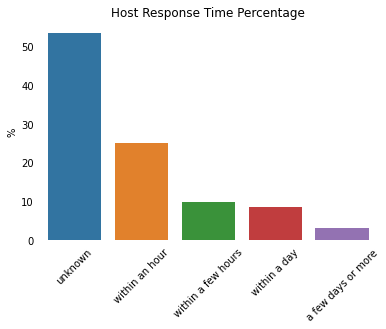

In [91]:
# Plotting the percentage of response time by time
ax = sns.barplot(response_time_perc.index, response_time_perc) 
ax.set_title('Host Response Time Percentage')
ax.tick_params(bottom=False, top=False, left=False, right=False);
ax.set_ylabel('%', fontsize=10)
ax.tick_params(axis='x', labelrotation=45)
for kew, spine in ax.spines.items():
    spine.set_visible(False)

### host__response_rate
+ about 1/2 of values are nulll
+ Because about ~62% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins

In [92]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Percent: {round((df.host_response_rate.isna().sum()/len(df))*100,1)}%")

Null values: 26839
Percent: 53.5%


In [93]:
# Remove the % sign from the host_response_rate string
# convert to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 89.0
Median host response rate: 100.0
Proportion of 100% host response rates: 62.1%


In [94]:

# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()


unknown    26839
100%       14460
50-89%      3735
90-99%      3145
0-49%       1954
Name: host_response_rate, dtype: int64

In [135]:
response_rate_perc = df.host_response_rate.value_counts() / df.shape[0]*100
response_rate_perc

unknown    53.535595
100%       28.843277
50-89%      7.450183
90-99%      6.273313
0-49%       3.897632
Name: host_response_rate, dtype: float64

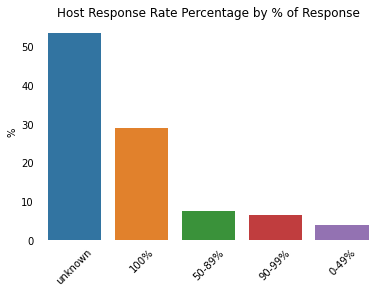

In [136]:
# Plotting the percentage of hsot response rates by %
ax = sns.barplot(response_rate_perc.index, response_rate_perc) 
ax.set_title('Host Response Rate Percentage by % of Response')
ax.tick_params(bottom=False, top=False, left=False, right=False);
ax.set_ylabel('%', fontsize=10)
ax.tick_params(axis='x', labelrotation=45)
for kew, spine in ax.spines.items():
    spine.set_visible(False)

### property_type
+ Some cleaning of property types is required as there are a large number of categories with only a few listings
+ The categories 'apartment', 'house','hotel' and 'other' will be used, as most properties can be classified as either apartments, houses, or hotels.

In [95]:
df['property_type'].value_counts()

Entire rental unit                     38191
Private room in rental unit             5053
Room in boutique hotel                  1714
Entire condominium (condo)              1519
Entire loft                              875
Room in hotel                            668
Private room in condominium (condo)      300
Entire residential home                  255
Shared room in rental unit               247
Entire serviced apartment                197
Private room in bed and breakfast        140
Entire townhouse                         133
Room in aparthotel                       107
Private room in residential home          90
Private room in loft                      90
Private room in townhouse                 72
Private room in guesthouse                49
Shared room in hostel                     45
Room in serviced apartment                42
Private room in hostel                    42
Private room                              34
Shared room in condominium (condo)        29
Entire gue

In [96]:
# Replacing categories that are types of houses, apartments, or hotels
df.property_type.replace({
    'Entire rental unit': 'House',
    'Entire condominium (condo)': 'Apartment',
    'Private room in rental unit': 'Apartment',
    'Entire loft': 'Apartment',
    'Entire residential home': 'House',
    'Entire serviced apartment': 'Apartment',
    'Entire townhouse': 'House',
    'Room in aparthotel': 'Apartment',
    'Earth house': 'House',
    'Room in hotel':'Hotel',
    'Private room in bed and breakfast':'House'
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment', 'Hotel']), 'property_type'] = 'Other'

In [137]:
df['property_type'].value_counts()

House        38721
Apartment     7751
Other         2993
Hotel          668
Name: property_type, dtype: int64

In [138]:
property_type_perc = df.property_type.value_counts() / df.shape[0]*100
property_type_perc

House        77.236551
Apartment    15.460874
Other         5.970119
Hotel         1.332456
Name: property_type, dtype: float64

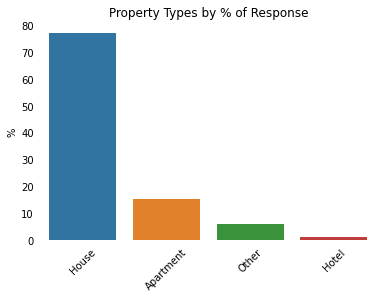

In [139]:
# Plotting the percentage of property type by %
ax = sns.barplot(property_type_perc.index, property_type_perc) 
ax.set_title('Property Types by %')
ax.tick_params(bottom=False, top=False, left=False, right=False);
ax.set_ylabel('%', fontsize=10)
ax.tick_params(axis='x', labelrotation=45)
for kew, spine in ax.spines.items():
    spine.set_visible(False)

### bedrooms, and beds
+ Missing values will be replaced with the median

In [97]:
for col in ['bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [98]:
df.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5396,within an hour,100%,89%,0.0,Saint-Paul - Ile Saint-Louis,1.0,1.0,1.0,"Paris, Ile-de-France, France",Hôtel-de-Ville,House,Entire home/apt,2,1 bath,1.0,1.0,"[""Hot water kettle"", ""Cooking basics"", ""Smoke alarm"", ""Oven"", ""Long term stays allowed"", ""Hot water"", ""Shampoo"", ""Heating"", ""Refrigerator"", ""Shower gel"", ""Essentials"", ""Bed linens"", ""Toaster"", ""Dedicated workspace"", ""Cleaning products"", ""Extra pillows and blankets"", ""Stove"", ""Drying rack for clothing"", ""Clothing storage: closet"", ""Fire extinguisher"", ""Body soap"", ""Cable TV"", ""Kitchen"", ""Hangers"", ""TV with standard cable"", ""Wifi"", ""Hair dryer"", ""Dishes and silverware"", ""Host greets you"", ""Washer""]",$110.00,2,1125,0,3,29,29,260,35,3,2013-09-22,2020-08-08,4.51,4.55,4.47,4.78,4.82,4.96,4.53,0,1,1,0,0,2.68
1,7397,within an hour,100%,80%,1.0,Le Marais,4.0,4.0,1.0,NaN,Hôtel-de-Ville,House,Entire home/apt,4,1 bath,2.0,2.0,"[""Cooking basics"", ""Smoke alarm"", ""Iron"", ""Oven"", ""Long term stays allowed"", ""Hot water"", ""Shampoo"", ""Heating"", ""Refrigerator"", ""Essentials"", ""Bed linens"", ""Microwave"", ""Dedicated workspace"", ""Extra pillows and blankets"", ""Stove"", ""Cable TV"", ""Kitchen"", ""Hangers"", ""Carbon monoxide alarm"", ""Paid parking off premises"", ""TV with standard cable"", ""Wifi"", ""Coffee maker"", ""Hair dryer"", ""Dishes and silverware"", ""Host greets you"", ""Washer""]",$100.00,10,130,0,0,20,257,278,9,2,2011-08-11,2021-08-18,4.70,4.79,4.44,4.91,4.88,4.92,4.70,0,1,1,0,0,2.26
2,7964,within a day,50-89%,0%,0.0,Gare du Nord - Gare de I'Est,0.0,0.0,1.0,NaN,Opéra,House,Entire home/apt,2,1 bath,1.0,1.0,"[""Essentials"", ""TV with standard cable"", ""Wifi"", ""Cable TV"", ""Dedicated workspace"", ""Kitchen"", ""Hangers"", ""Iron"", ""Long term stays allowed"", ""Heating"", ""Washer""]",$130.00,6,365,13,43,73,348,6,0,0,2014-09-11,2015-09-14,4.80,5.00,5.00,5.00,5.00,5.00,5.00,0,1,1,0,0,0.07
3,9359,within an hour,100%,20%,0.0,Châtelet - Les Halles - Beaubourg,3.0,3.0,1.0,NaN,Louvre,House,Entire home/apt,2,1 bath,1.0,1.0,"[""Essentials"", ""Wifi"", ""Kitchen"", ""Hair dryer"", ""Elevator"", ""Long term stays allowed"", ""Heating""]",$75.00,180,365,0,0,0,28,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,0,0,NaN
4,9952,within an hour,100%,100%,1.0,République,1.0,1.0,1.0,"Paris, Ile-de-France, France",Popincourt,House,Entire home/apt,2,1 bath,1.0,1.0,"[""TV"", ""Cooking basics"", ""Smoke alarm"", ""Luggage dropoff allowed"", ""Iron"", ""Oven"", ""Long term stays allowed"", ""Hot water"", ""Heating"", ""Refrigerator"", ""Shower gel"", ""Essentials"", ""Bed linens"", ""Microwave"", ""Dedicated workspace"", ""Extra pillows and blankets"", ""Stove"", ""First aid kit"", ""Kitchen"", ""Hangers"", ""Paid parking off premises"", ""Wifi"", ""Coffee maker"", ""Hair dryer"", ""Dishes and silverware"", ""Host greets you""]",$80.00,4,31,1,2,2,198,31,6,1,2016-08-04,2021-06-23,4.94,4.97,4.87,5.00,4.90,4.90,4.94,0,1,1,0,0,0.50


### amenities

In [99]:
# Example of amenities listed
df.amenities[:1].values

array(['["Hot water kettle", "Cooking basics", "Smoke alarm", "Oven", "Long term stays allowed", "Hot water", "Shampoo", "Heating", "Refrigerator", "Shower gel", "Essentials", "Bed linens", "Toaster", "Dedicated workspace", "Cleaning products", "Extra pillows and blankets", "Stove", "Drying rack for clothing", "Clothing storage: closet", "Fire extinguisher", "Body soap", "Cable TV", "Kitchen", "Hangers", "TV with standard cable", "Wifi", "Hair dryer", "Dishes and silverware", "Host greets you", "Washer"]'],
      dtype=object)

In [100]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'Safe',
 'Children\\u2019s books and toys for ages 5-10 years old and 10+ years old',
 'Host greets you] [Long term stays allowed] [Essentials',
 'Plaque et four philips  induction stove',
 '40\\ HDTV with standard cable',
 'premium cable',
 'Hair dryer] [Children\\u2019s dinnerware',
 'Complimentary breakfast',
 'Elevator] [Wifi',
 'bose Bluetooth sound system',
 'Terrace',
 'Bosch stainless steel stove',
 'Lockbox',
 'LG oven',
 'Free street parking] [Wifi',
 'Alarm system',
 'Long term stays allowed] [] [TV',
 'Washer] [Samsung refrigerator',
 'Loreal conditioner',
 'Alexa Bluetooth sound system',
 'Cartier shampoo',
 'Head & Shoulders 2-in-1 conditioner',
 'X shampoo',
 'X stainless steel electric stove',
 'Enceinte Bose  Bluetooth sound system',
 'Ushuaia body soap',
 'Air conditioning] [Restaurant',
 'Host greets you] [Refrigerator',
 'Continental breakfast available \\u2014 \\u20ac14 per person per day',
 'Electric stove] [Refrigerator',
 'Stainless steel induction stove',
 'Co

+ In the list above, some amenities are more important than others (e.g. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (e.g. 'Electric profiling bed')
+ The amenities chosen are

In [101]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

+ One way to reduce the number of features (to avoid the curse of dimensionality) is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings


In [102]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['calculated_host_listings_count_shared_rooms', 'check_in_24h', 'high_end_electronics', 'bbq', 'balcony', 'nature_and_views', 'gym', 'child_friendly', 'outdoor_space', 'hot_tub_sauna_or_pool', 'pets_allowed', 'secure', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


### price
+ Price will be converted to an integer - currently it is a string because there is a currency sign

In [103]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

### availability
+ There are multiple different measures of availability, which will be highly correlated with each other. Only one will be retained - for 90 days

In [104]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [105]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 22.8%
Null values in 'review_scores_rating': 22.8%


In [106]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2021, 9, 9) - df.first_review).astype('timedelta64[D]')

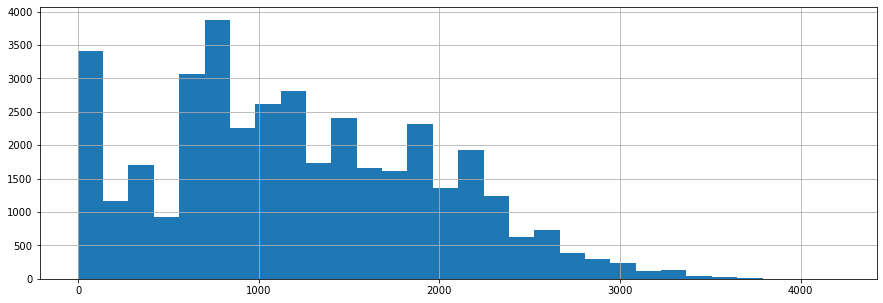

In [107]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [108]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [109]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

+ The same process will be followed for last_review:

In [110]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2021, 9, 9) - df.last_review).astype('timedelta64[D]')


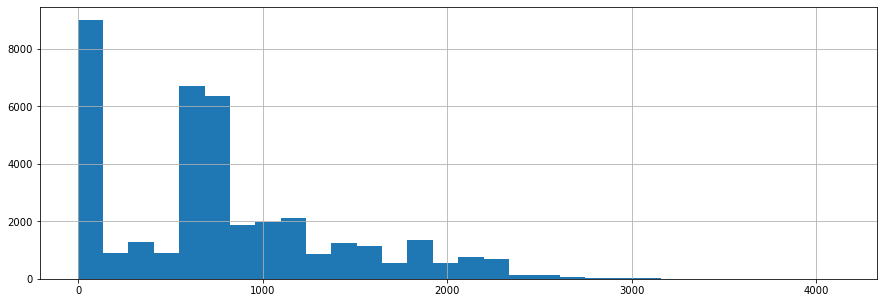

In [111]:

# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [112]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [113]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

### review rating columns
+ As above, listings without reviews will be kept and replaced with 'unknown'. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below.

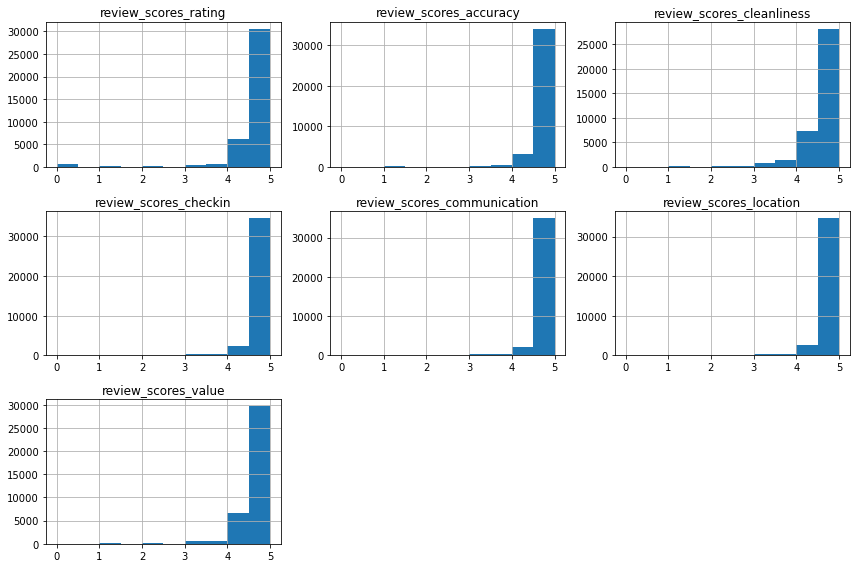

In [114]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [115]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [116]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [117]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [118]:
df.head()

,id,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,price,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,reviews_per_month,air_conditioning,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,parking,host_greeting,internet,long_term_stays,private_entrance,time_since_first_review,time_since_last_review
0,5396,within an hour,100%,89%,0.0,Saint-Paul - Ile Saint-Louis,1.0,1.0,1.0,"Paris, Ile-de-France, France",Hôtel-de-Ville,House,Entire home/apt,2,1 bath,1.0,1.0,110,2,1125,29,260,35,3,2013-09-22,0-79/100,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,0,1,1,0,2.68,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,4+ years,1+ year
1,7397,within an hour,100%,80%,1.0,Le Marais,4.0,4.0,1.0,NaN,Hôtel-de-Ville,House,Entire home/apt,4,1 bath,2.0,2.0,100,10,130,20,278,9,2,2011-08-11,0-79/100,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,0,1,1,0,2.26,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,4+ years,2-8 weeks
2,7964,within a day,50-89%,0%,0.0,Gare du Nord - Gare de I'Est,0.0,0.0,1.0,NaN,Opéra,House,Entire home/apt,2,1 bath,1.0,1.0,130,6,365,73,6,0,0,2014-09-11,0-79/100,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,0,1,1,0,0.07,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,4+ years,1+ year
3,9359,within an hour,100%,20%,0.0,Châtelet - Les Halles - Beaubourg,3.0,3.0,1.0,NaN,Louvre,House,Entire home/apt,2,1 bath,1.0,1.0,75,180,365,0,0,0,0,NaT,nan,nan,nan,nan,nan,nan,nan,0,1,1,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,nan,nan
4,9952,within an hour,100%,100%,1.0,République,1.0,1.0,1.0,"Paris, Ile-de-France, France",Popincourt,House,Entire home/apt,2,1 bath,1.0,1.0,80,4,31,2,31,6,1,2016-08-04,0-79/100,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,0-8/10,0,1,1,0,0.50,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,4+ years,2-6 months


### number_of_reviews_ltm and reviews_per_month

In [119]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

## Exploratory Data Analysis

In [120]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.first_review).strftime('%d %B %Y')}, and the most recent joined on {max(df.first_review).strftime('%d %B %Y')}.")


Of the Airbnb hosts that are still listing on the site, the first joined on 28 February 2010, and the most recent joined on 11 September 2021.


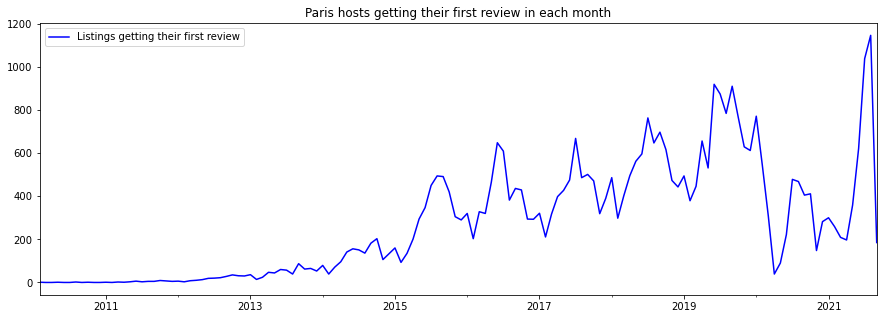

In [121]:

plt.figure(figsize=(15,5))
#df.set_index('first_review').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='blue')
plt.title('Paris hosts getting their first review in each month')
plt.legend()
plt.xlim('2010-02-28', '2021-09-11') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [122]:
# Creating dataframes for time series analysis
#ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
#ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
#ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [123]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

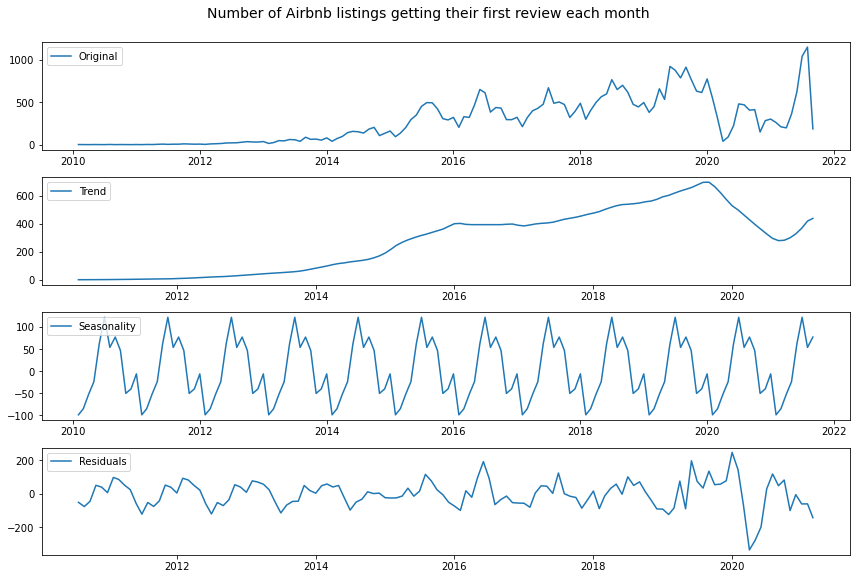

In [124]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

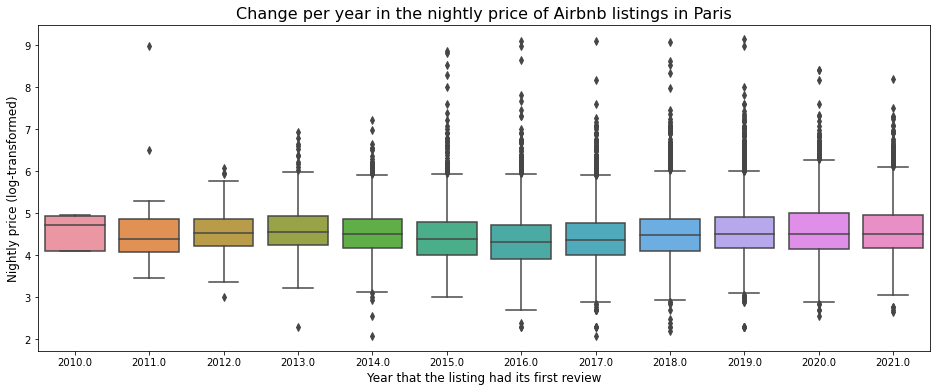

In [125]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Paris', fontsize=16)
plt.show()

In [126]:
print("Mean nightly price of listings in each year on Airbnb in Paris:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Paris:
first_review
2010-01-01    102.60
2011-01-01    271.23
2012-01-01    111.09
2013-01-01    122.48
2014-01-01    114.46
2015-01-01    110.00
2016-01-01    105.70
2017-01-01    108.04
2018-01-01    121.41
2019-01-01    125.18
2020-01-01    129.29
2021-01-01    123.84
Name: price, dtype: float64


## Numerical features

In [127]:
df.describe()

,id,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,air_conditioning,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,parking,host_greeting,internet,long_term_stays,private_entrance
count,5.013300e+04,50099.000000,50099.000000,50099.000000,50099.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,5.013300e+04,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000,50133.000000
mean,2.594199e+07,0.137767,13.056009,13.056009,0.796982,3.053019,1.303712,1.680969,125.892646,112.930226,9.999625e+02,23.034049,20.834600,0.394112,0.318612,14.621766,13.887579,0.472643,0.118844,0.411705,0.120420,0.681786,0.423793,0.471965,0.770112,0.383879,0.275447,0.191969,0.942453,0.874733,0.153990
std,1.566613e+07,0.344659,79.416380,79.416380,0.402250,1.637042,0.928761,1.377628,218.690543,170.370611,4.466482e+04,33.142745,44.955323,1.593299,0.465943,58.703275,58.674007,2.204135,0.323608,0.492147,0.325455,0.465788,0.494163,0.499218,0.420765,0.486334,0.446744,0.393853,0.232887,0.331024,0.360943
min,5.396000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.214614e+07,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,60.000000,2.000000,2.400000e+02,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,2.544425e+07,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,88.000000,4.000000,1.125000e+03,0.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,4.004825e+07,0.000000,2.000000,2.000000,1.000000,4.000000,1.000000,2.000000,135.000000,365.000000,1.125000e+03,50.000000,21.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,5.216600e+07,1.000000,1105.000000,1105.000000,1.000000,16.000000,50.000000,90.000000,11600.000000,9999.000000,1.000000e+07,90.000000,1596.000000,208.000000,1.000000,500.000000,500.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [128]:
print(f"Nightly advertised prices range from €{min(df.price)} to €{max(df.price)}.")

Nightly advertised prices range from €0 to €11600.


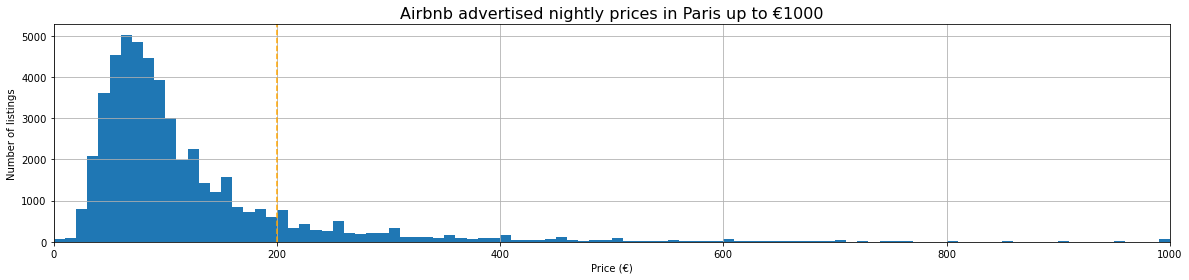

In [129]:
# Distribution of prices from €0 to €1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Paris up to €1000", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

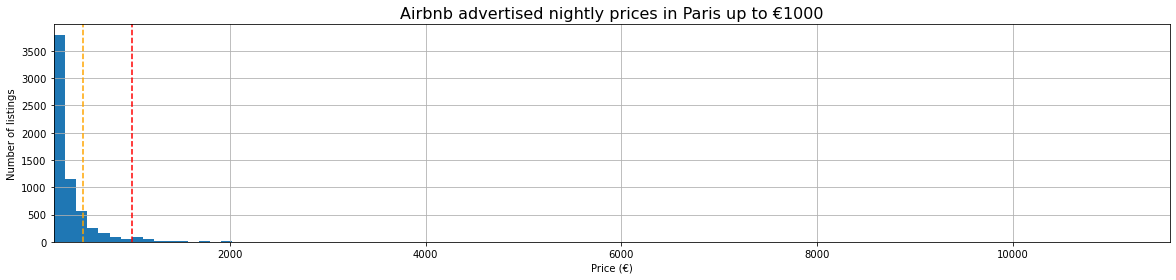

In [130]:
# Distribution of prices from €200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Paris up to €1000", fontsize=16)
plt.xlabel("Price (€)")
plt.ylabel("Number of listings")
plt.show()

In [131]:
# Replacing values under €10 with €10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over €1000 with €1000
df.loc[df.price >= 1000, 'price'] = 1000

In [132]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 13
55% of listings are from hosts with one listing.


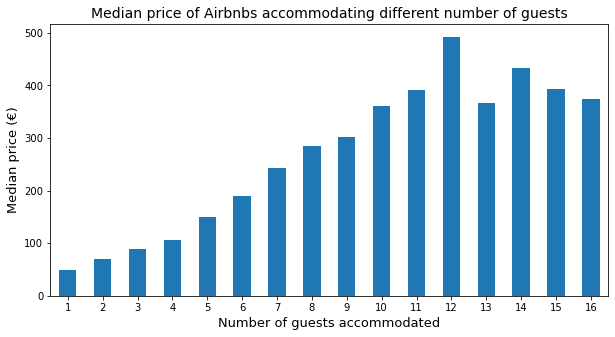

In [133]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (€)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

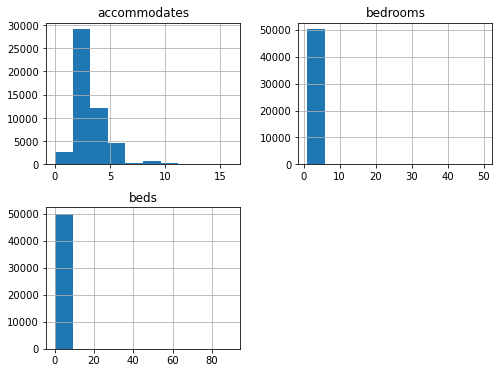

In [134]:
df[['accommodates', 'bedrooms', 'beds']].hist(figsize=(8,6));